<a href="https://colab.research.google.com/github/lesi-nedo/ISPR_assignments/blob/main/assignment_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" ><b> <font face="Rage" size=7 >RBM From Scratch</font></b></div>

<div align="center" ><b> <font face="Rage" size=5 >Assignment 3</font></b></div>
<div align="center" ><b> <font face="Rage" size=4 >Oleksiy Nedobiychuk</font></b></div>


## Setup and Download the Dataset

In [1]:
import gzip
import os
from urllib.request import urlretrieve

train_img_url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
train_label_url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

current_dir = os.getcwd()
train_imgs_name_f = 'train_imgs.gz'
label_imgs_name_f = 'train_labels.gz'
train_img_path = None
train_label_path = None


def check_or_download(url, file_name):
    path = None
    if not os.path.exists(file_name):
        path, _ = urlretrieve(url, file_name)
        print(f"Downloaded {file_name}")
    else:
        pwd = os.getcwd()
        path = os.path.abspath(f"{pwd}/{file_name}")
        print(f"{file_name} already exists")
    return path


path_imgs = check_or_download(train_img_url, train_imgs_name_f)
path_labels = check_or_download(train_label_url, label_imgs_name_f)




with gzip.open(path_imgs, 'rb') as train_imgs_f:
    train_imgs = train_imgs_f.read()

with gzip.open(path_labels, 'rb') as train_labels_f:
    train_labels = train_labels_f.read()


Downloaded train_imgs.gz
Downloaded train_labels.gz


## Read the data from the file to the memory

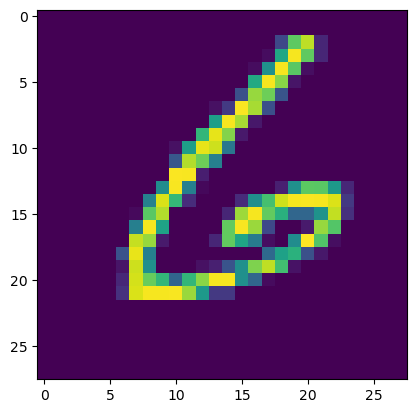

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

image_size = 28
num_images = 60000

data = np.frombuffer(train_imgs, dtype=np.uint8, count=image_size*image_size*num_images, offset=16).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

image = np.asarray(data[59998]).squeeze()
plt.imshow(image)
plt.show()

## Image Binary Encoding

I applied a threshold to the image in order to create a binary representation of each of them


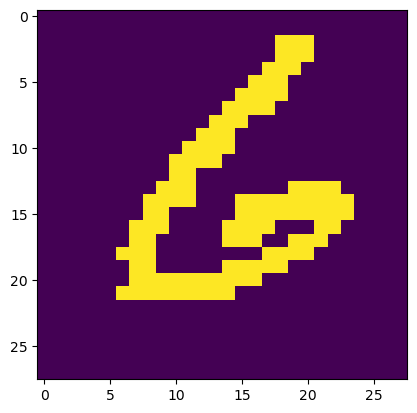

In [3]:
threshold = 30

data[data < threshold] = 0
data[data >= threshold] = 1
data = data.astype(np.float32)
image = np.asarray(data[59998]).squeeze()
plt.imshow(image)
plt.show()



## Calculating the intial visible bias

I came across an interesting PDF titled "A Practical Guide to Training Restricted Boltzmann Machines". It discussed calculating the bias as ([link](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)): "It is usually helpful to initialize the bias of visible unit i to log\[pi/(1−pi)\] where p_i is the proportion
of training vectors in which unit i is on". I hope, I translated the sentence correctly into below code.

In [4]:
len_v_vec = data.shape[1] * data.shape[2]
def getVbias(dataset):
    data = dataset.reshape(dataset.shape[0], len_v_vec)
    p = np.count_nonzero(data, axis=0)/data.shape[0]
    p = p/(1-p)
    p[p == 0] = 1.0
    return np.log(p)

bias_visible = getVbias(data)

In [6]:


class Trainable():

    def __init__(self, num_row, num_column) -> None:
        self.weights = np.random.normal(loc=0.0, scale=0.01, size=(num_row, num_column))
        self.prev_gw = np.zeros(self.weights.shape)
        self.prev_gbv = np.zeros(num_row)
        self.prev_gbh = np.zeros(num_column)
        self.t_iter = 0
        self.prev_p_h0 = np.zeros(num_column)



    def compile(self, batch_size, epochs, learning_rate, weight_cost, momentum):
        self.batch_size = batch_size
        self.epoch_size = epochs
        self.learning_rate = learning_rate
        self.weight_cost = weight_cost
        self.momentum = momentum

        return self

    def calculate_gradient(self, data):
        pass

    def predict(self, data):
        pass

    def update_weights(self, gradient):
        self.weights += gradient['gw']


## The Implementation of the Restricted Boltzmann Machine

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def bernoulli(p):
    return (np.random.binomial(n=1, p=p, size=p.shape))





class RBM(Trainable):
    def __init__(self, num_visible_units, num_hidden_units, biasV=None) -> None:
        self.num_hidden_units = num_hidden_units
        self.num_visible_units = num_visible_units


        self.biasH = np.random.uniform(low=-0.000001, high=0.000001, size=(self.num_hidden_units, 1)).squeeze()
        self.biasV = biasV if biasV is not None else np.random.uniform(low=-1, high=1, size=(self.num_visible_units, 1)).squeeze()
        super().__init__(self.num_visible_units, self.num_hidden_units)



    @property
    def num_visible(self):
        return self.num_visible_units

    @property
    def num_hidden(self):
        return self.num_hidden_units

    def sample_hidden(self, visible_units):
        activation = (visible_units @ self.weights) + self.biasH
        h1_mean = sigmoid(activation)
        return h1_mean, bernoulli(h1_mean)

    def sample_visible(self, hidden_units):
        activation = (hidden_units @ self.weights.T) + self.biasV
        v1_mean = sigmoid(activation)
        return v1_mean, bernoulli(v1_mean)

    def get_energy(self, visible_units):
        hidden_units = self.sample_hidden(visible_units)
        s = visible_units.T @ self.weights @ hidden_units[1]
        return ( - s - self.biasH.T @ hidden_units[1]- self.biasV.T @ visible_units).sum()

    def gibbs_sampling(self, visible_units):
        visible_units = np.zeros((1, self.num_visible_units)), visible_units
        while True:
            hidden_units = self.sample_hidden(visible_units[1])
            yield visible_units, hidden_units
            visible_units = self.sample_visible(hidden_units[1])

    def update_weights(self, gradient):
        return super().update_weights(gradient)

    # Remember v1, h1 are tuples of (probability, sampled)
    # Remember each value of key is a tuple of (v1, h1)
    def predict_h1(self, data):
        print(data.flatten().shape)
        if data.ndim == 3:
            data = data.flatten()
            passes = self.gibbs_sampling(data)
            v0, h0 = next(passes)
            v1, h1 = next(passes)
            print(v1)
            return v1,h1
        else:
            data = data.reshape(data.shape[0], self.num_visible_units)
            predictions = {}
            for i, d in tqdm.tqdm(enumerate(data)):
                passes = self.gibbs_sampling(d)
                v0, h0 = next(passes)
                v1, h1 = next(passes)
                predictions.update({i: (v1, h1)})
            return predictions

    def train(self, data):
        data = data.reshape(data.shape[0], self.num_visible_units).copy()
        total_size = data.shape[0]
        energy_error = []
        error = []
        for epoch in range(self.epoch_size):
            error.append([])
            energy_error.append([])
            print(f"Epoch {epoch+1} out of {self.epoch_size}")
            for i in tqdm.tqdm(range(0, len(data), self.batch_size)):
                if i + self.batch_size > total_size:
                    self.batch_size = total_size - i
                batched_data = data[i:i+self.batch_size]
                gradient = self.calculate_gradient(batched_data)
                self.update_weights(gradient)
                self.biasV += gradient['gbv']
                self.biasH += gradient['gbh']
                energy_error[epoch].append(gradient['energy_error'])
                error[epoch].append(gradient['error'])

                del gradient
            plt.hist(self.weights.flatten(), bins='auto')
            plt.title("Histogram of Weights -- Epoch {}".format(epoch+1))
            plt.show()
            plt.hist(self.biasV, bins='auto')
            plt.title("Histogram of Visible Bias -- Epoch {}".format(epoch+1))
            plt.show()
            plt.hist(self.biasH, bins='auto')
            plt.title("Histogram of Hidden Bias -- Epoch {}".format(epoch+1))
            plt.show()

            self.prev_p_h0 /= data.shape[0]
            prob_img = self.prev_p_h0.reshape(32, 32)
            plt.imshow(prob_img, cmap='gray')
            plt.title("The Average Probability of Hidden Units of the batch")
            plt.show()
            self.prev_p_h0 = np.zeros(self.num_hidden_units)



            if self.momentum < 0.9 and epoch == self.epoch_size // 3:
                self.momentum += (0.9 - self.momentum) / (self.epoch_size / 2)

            print(f"Epoch Mean Square Error {np.array(np.mean(error[epoch]))} ---- Energy Error {np.array(energy_error[epoch]).mean()}")
        return self.weights, self.biasV, self.biasH, energy_error, error

    def calculate_gradient(self, batched_data):

        np.random.shuffle(batched_data)

        updates = {"gw": np.zeros(self.weights.shape), "gbv": np.zeros(self.biasV.shape), "gbh": np.zeros(self.biasH.shape), "energy_error": 0, "error": 0}


        def calc_deltas(data, updates):
            passes = self.gibbs_sampling(data)
            v0, h0 = next(passes) # v0[0] is the 0 vector of the visible units, v0[1] is the actual data
            v1, h1 = next(passes) # v1[0] is the probability    , v1[1] is the sampled visible units
            updates['gw'] += (np.outer(v0[1].T, h0[0]) - np.outer(v1[1].T, h1[0]))

            updates['gbv'] += (np.sum(v0[1]) - np.sum(v1[0]))
            updates['gbh'] += (np.sum(h0[1]) - np.sum(h1[0]))

            updates['error'] += np.mean((v0[1] - v1[1])**2)
            self.prev_p_h0 += h0[0]
            updates['energy_error'] += (self.get_energy(v0[1]) - self.get_energy(v1[1])).mean()
            return data
        np.apply_along_axis(calc_deltas, 1, batched_data, updates)
        updates['gw'] /= self.batch_size
        updates['gbv'] /= self.batch_size
        updates['gbh'] /= self.batch_size
        updates['gw'] = self.momentum * self.prev_gw + (1. - self.momentum) * updates['gw']
        updates['gbv'] = self.momentum * self.prev_gbv + (1. - self.momentum) * updates['gbv']
        updates['gbh'] = self.momentum * self.prev_gbh + (1. - self.momentum) * updates['gbh']
        self.prev_gbv = updates['gbv']
        self.prev_gbh = updates['gbh']
        self.prev_gw = updates['gw']
        updates['gw'] = self.learning_rate * (updates['gw'] - self.weight_cost * self.weights)
        updates['gbv'] = self.learning_rate * updates['gbv']
        updates['gbh'] = self.learning_rate * updates['gbh']
        updates["energy_error"] /= self.batch_size
        updates["error"] /= self.batch_size

        self.prev_p_h0 /= self.batch_size
        return updates



rbm = RBM(len_v_vec, 1024, bias_visible)

The training process updates the parameters in batches, leveraging momentum, L2 regularization, and a learning rate to optimize the model. For each piece of data, it computes the positive phase (wake) and the negative phase (dream) and accumulates the difference. Same for the visible and hidden biases. This sum is then divided by the batch size to obtain the average gradient. To improve clarity, I've chosen to calculate the update for the weight parameters as follows: $v_i = \operatorname{momentum} \cdot v_{i-1} + (1 - \operatorname{momentum}) \cdot v_i$.

## Train the model

Starts with 0.5 momentum, but then increases it after the third (beacuse it is 10) epoch to: $\frac{2 \cdot (0.9 - \operatorname{self.momentum})}{\operatorname{self.epoch_size }}$. The maximum is 0.9

In [ ]:
conf = {
    "momentum": 0.5,
    "weight_cost": 0.000002,
    "learning_rate": 0.09,
    "epochs": 10,
    "batch_size": 128,
}

rbm.compile(**conf)
r = rbm.train(data)

In [ ]:
image = rbm.predict_h1(data[0].squeeze().reshape(1, len_v_vec))
image = image[0][0][0].reshape(28, 28)


plt.imshow(image)
plt.title("Sigmoid values of the Visible Units")
plt.show()

Without significant parallelization, training takes a long time. To expedite future use, let's save the current model to a local file for reuse.

In [ ]:
# from io import StringIO
# import json
# weights = rbm.weights
# biasH = rbm.biasH
# biasV = rbm.biasV

# def array_2_string(array):
#     str_out = StringIO()
#     np.savetxt(str_out, array)
#     return str_out.getvalue()

# rbm_dict = {"weights": array_2_string(weights), "biasH": array_2_string(biasH), "biasV": array_2_string(biasV)}
# with open("rbm_model.json", "w") as f:
#     json.dump(rbm_dict, f, indent=4, sort_keys=True)
#     f.flush()

In [16]:
def string_2_array(string):
    str_in = StringIO(string)
    array_tmp = np.loadtxt(str_in)
    if len(array_tmp.shape) == 0:
        return np.array([array_tmp])
    return array_tmp

rbm_dict = {}

with open("rbm_model.json", "r") as f:
    model = json.load(f)
    rbm_dict = {"weights": string_2_array(model["weights"]), "biasH": string_2_array(model["biasH"]), "biasV": string_2_array(model["biasV"])}



In [17]:
test_url = "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
test_label_url = "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"

test_imgs_name_f = 'test_imgs.gz'
test_label_imgs_name_f = 'test_labels.gz'

path_test_imgs = check_or_download(test_url, test_imgs_name_f)
path_test_labels = check_or_download(test_label_url, test_label_imgs_name_f)

with gzip.open(path_test_imgs, 'rb') as test_imgs_f:
    test_imgs = test_imgs_f.read()

with gzip.open(path_test_labels, 'rb') as test_labels_f:
    test_labels = test_labels_f.read()


Downloaded test_imgs.gz
Downloaded test_labels.gz


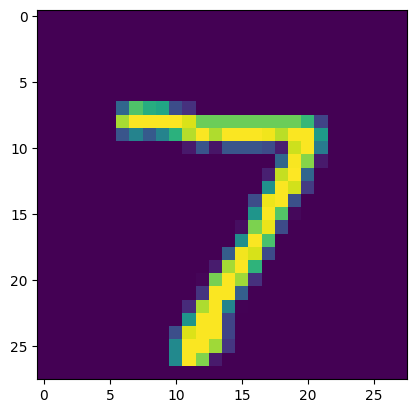

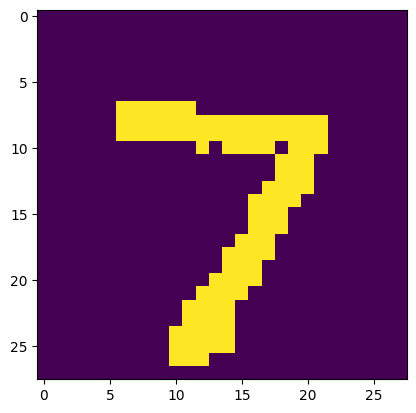

In [18]:
test_data = np.frombuffer(test_imgs, dtype=np.uint8, count=image_size*image_size*10000, offset=16).astype(np.float32)
test_data = test_data.reshape(10000, image_size, image_size, 1)
test_data_size = test_data.shape[0]
image = np.asarray(test_data[0]).squeeze()
plt.imshow(image)
plt.show()

test_data[test_data < threshold] = 0.0
test_data[test_data >= threshold] = 1.0

image = np.asarray(test_data[0]).squeeze()
plt.imshow(image)
plt.show()


(7840000,)


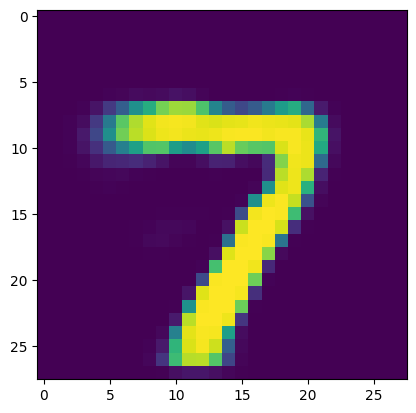

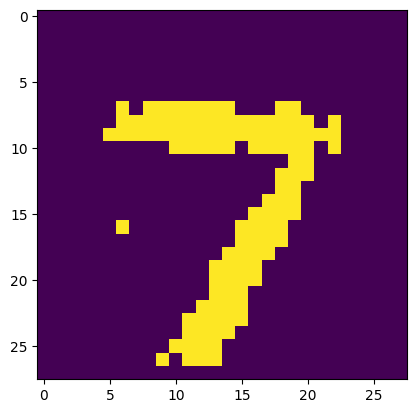

In [31]:
pred_test = rbm.predict_h1(test_data)
image = pred_test[0][0][0].reshape(28, 28)
plt.imshow(image)
plt.show()

image = pred_test[0][0][1].reshape(28, 28)
plt.imshow(image)
plt.show()

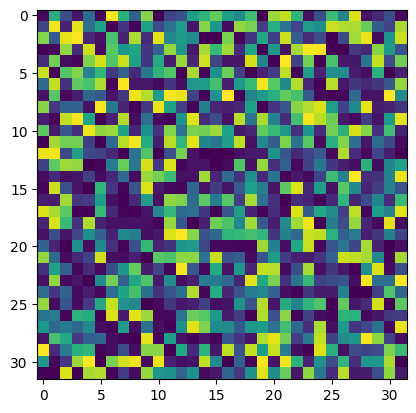

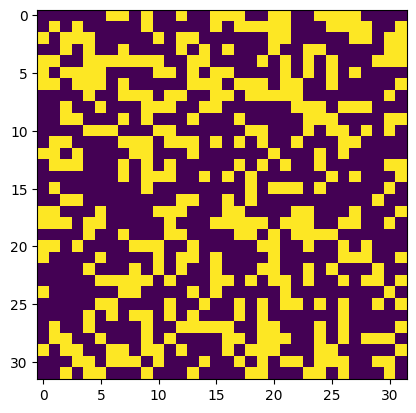

In [32]:
image = pred_test[0][1][0].reshape(32, 32)
plt.imshow(image)
plt.show()

image = pred_test[0][1][1].reshape(32, 32)
plt.imshow(image)


In [43]:
import seaborn as sns
import statistics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [22]:
test_data_labels = np.frombuffer(test_labels, dtype=np.uint8, count=test_data_size, offset=8)
test_data_h1 = np.zeros((test_data_size, rbm.num_hidden_units))


for key, value in pred_test.items():
    test_data_h1[key] = value[1][0]

<Axes: ylabel='Density'>

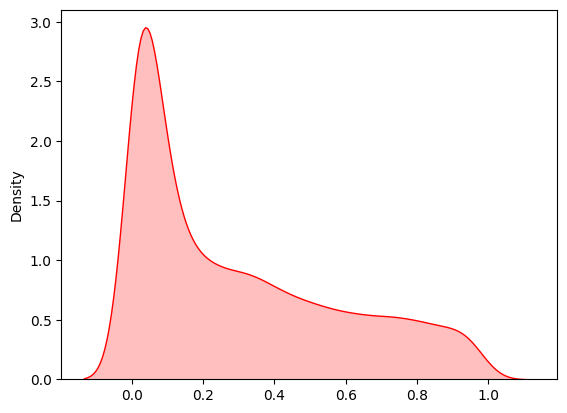

In [23]:
sns.kdeplot(test_data_h1[:, 0], label="H1", fill=True, color="r")

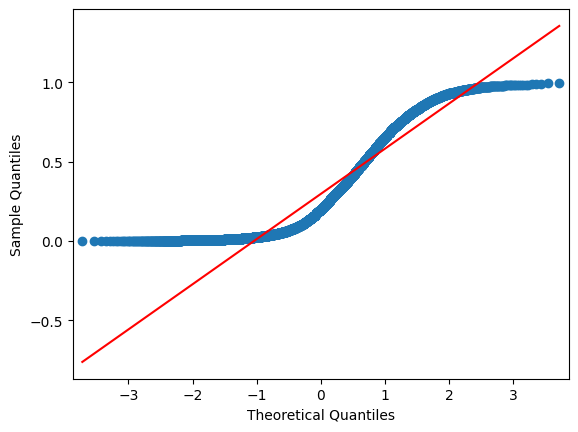

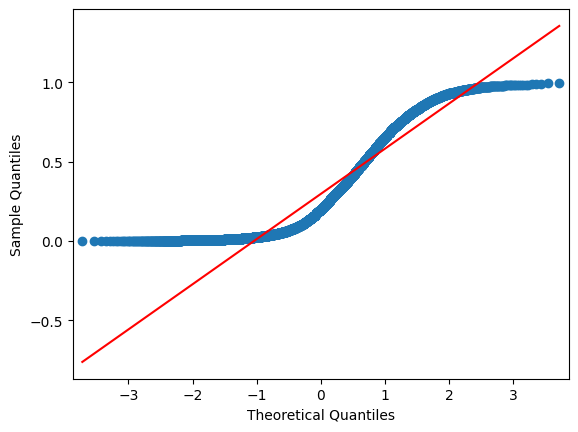

In [24]:
from statsmodels.graphics.gofplots import qqplot


qqplot(test_data_h1[:, 0], line='s')

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
X_train, X_test, y_train, y_test = train_test_split(test_data_h1, test_data_labels, test_size=0.33, random_state=42)

nb = clf.fit(X_train, y_train)

In [35]:
nb.score(X_test, y_test)

0.7715151515151515

<Axes: >

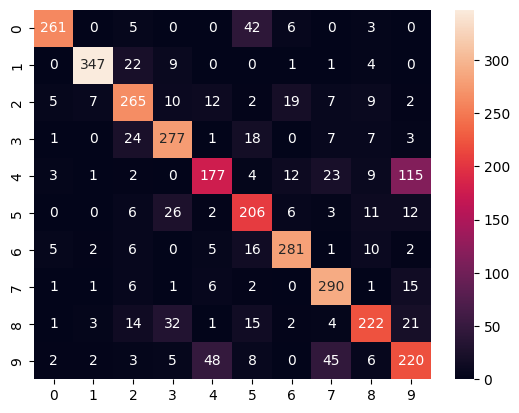

In [36]:
sns.heatmap(confusion_matrix(y_test, nb.predict(X_test)), annot=True, fmt='d')

In [46]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=42, max_iter=300)

nb1 = clf.fit(X_train, y_train)


In [47]:
nb1.score(X_test, y_test)

0.9415151515151515

<Axes: >

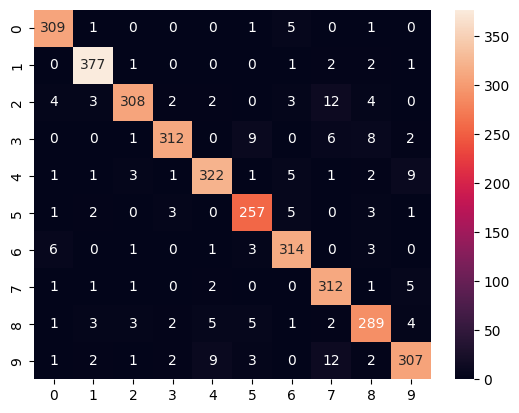

In [48]:
sns.heatmap(confusion_matrix(y_test, nb1.predict(X_test)), annot=True, fmt='d')